In [34]:
import os


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model

# Assignment 4 - Transfer Learning

The task of the assignment #4 is Transfer Learning using a CNN pretrained on IMAGENET.
The suggested architecture is the VGG16.

The CNN should be used as fixed feature extractor on a new task of your choice containing a number of classes in the range from 2 to 10.

## Task: Food Classification

The dataset is the Food-5K dataset available on [EPFL - Food Image Dataset](https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/) which contains 2500 food and 2500 non-food images.

The task is to train a DL model to recognize whether the given image contains any kind of food (labelled as `FOOD`) or not (labelled as `NON_FOOD`).

For this assignment I decided to use a smaller subset of images for the train and test sets. The former is composed with 2000 images (1000 for each class), while the latter consists of 1000 images (500 for each class).

This decision was led because of the computational storage and power needed to use the whole dataset on VGG16 cut at bottom layers (`block2` and `block3`).


## Feature Extraction: VGG16 Architecture
For the assignment we were suggested to use the VGG16 pretrained network as a feature extractor by considering different layers.
I decided to test 5 different cut points marked by orange arrows on the picture below. More specifically:

- Conv3/Max Pooling
- Conv4/Max Pooling
- Conv5/Max Pooling
- Fully Connected 1
- Fully Connected 2

For each cut point the program will process each image with the resulting VGG network (which works as a feature extractor). The lower the level where the network is cut, the higher the number of produced features.

The feature vectors obtained with this method will be used to train and test a Logistic Regression Classifier on the food classification task.


<img src="resources/VGG16-full.png" />

In [2]:
input_dir = os.path.join(os.getcwd(), 'input')

We can start by defining some functions to simplify the code structure.

Intensive tasks like the image prediction with VGG and feature classification with logistic regression store their respective output in a CSV file.

These functions allows to run the exact same task on different models provided as parameter to the main entrypoint function called `run_with_model`. The output consist of predicted class values paired with the ground truth.

In [3]:
def predict_image(model, image_path, label):
    input_image = image.load_img(image_path, target_size=(224, 224))

    # Shape: (samples in batch, rows, columns, depth)
    np_image = np.expand_dims(image.img_to_array(input_image), axis=0)
    np_image = preprocess_input(np_image)

    features = model.predict(np_image)
    return [label, *features.flatten()]


def process_folder(model, dataset_path, label):
    (root, _, files) = next(os.walk(os.path.join(dataset_path, label)))
    image_paths = list(map(lambda f: os.path.join(root, f), files))

    print(' - Processing {} images tagged as {}.'.format(len(image_paths), label.upper()))

    return list(map(lambda f: predict_image(model, f, label), image_paths))


def run_for_folder(model, input_dir, kind='train'):
    model_type, _ = model.output.name.split('/')
    print('> Analyzing {} dataset:'.format(kind))

    input_dir = os.path.join(input_dir, kind)
    food_images = process_folder(model, input_dir, 'food')
    non_food_images = process_folder(model, input_dir, 'non_food')

    print(' - Saving predicted features to CSV.')
    df = pd.DataFrame([*food_images, *non_food_images]).rename(columns={0: 'Class'})
    df.to_csv('VGG16-{}-{}.csv'.format(model_type, kind))
    
    return df


def classify(name, train_df, test_df):
    print('> Starting Logistic Regression Classifier...')

    X_train, Y_train = train_df.drop('Class', axis=1), train_df[['Class']]
    X_test, Y_test = test_df.drop('Class', axis=1), test_df[['Class']]
    print(' - Train: {}'.format(X_train.shape))
    print(' - Test: {}'.format(X_test.shape))

    lr_model = LogisticRegression()
    lr_model.fit(X_train, Y_train)

    predicted = lr_model.predict(X_test)
    print(' - Saving LRC predictions to CSV.')
    np.savetxt('LR-{}.csv'.format(name), predicted, fmt='%s')

    return (predicted, Y_test)


def run_with_model(name, model, input_dir):
    print('*** VGG16/{} layer runninng ***'.format(name))
    train = run_for_folder(model, input_dir, 'train')
    test = run_for_folder(model, input_dir, 'test')

    return classify(name, train, test)

In [4]:
base_model = VGG16(weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
results = {}

### Conv3/MaxPooling
The first cut is the most computationally expensive one. Every image will produce a massive vector of `28*28*256=200704` features that needs a lot of RAM and storage (for the CSV output) to be handled properly.

In [6]:
block3_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('block3_pool').output
)
block3_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [7]:
results['block3_pool'] = run_with_model('block3', block3_model, input_dir)

*** VGG16/block3 layer runninng ***
> Analyzing train dataset:
 - Processing 1000 images tagged as FOOD.
 - Processing 1000 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Analyzing test dataset:
 - Processing 500 images tagged as FOOD.
 - Processing 500 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Starting Logistic Regression Classifier...
 - Train: (2000, 200704)
 - Test: (1000, 200704)
 - Saving LRC predictions to CSV.


### Conv4/MaxPooling
In this case, every image will produce `14*14*512=100.352` features.

In [8]:
block4_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('block4_pool').output
)
block4_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
results['block4_pool'] = run_with_model('block4', block4_model, input_dir)

*** VGG16/block4 layer runninng ***
> Analyzing train dataset:
 - Processing 1000 images tagged as FOOD.
 - Processing 1000 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Analyzing test dataset:
 - Processing 500 images tagged as FOOD.
 - Processing 500 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Starting Logistic Regression Classifier...
 - Train: (2000, 100352)
 - Test: (1000, 100352)
 - Saving LRC predictions to CSV.


### Conv5/MaxPooling
In this case, every image will produce a feature vector with `7*7*512=25088` elements.

In [10]:
# Cut before top layers (after ConvLayers)
block5_model = VGG16(weights='imagenet', include_top=False)
block5_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
results['block5_pool'] = run_with_model('block5', block5_model, input_dir)

*** VGG16/block5 layer runninng ***
> Analyzing train dataset:
 - Processing 1000 images tagged as FOOD.
 - Processing 1000 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Analyzing test dataset:
 - Processing 500 images tagged as FOOD.
 - Processing 500 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Starting Logistic Regression Classifier...
 - Train: (2000, 25088)
 - Test: (1000, 25088)
 - Saving LRC predictions to CSV.


### Fully Connected
The two remaining cut points on FC1 and FC2 layers, for each image will both produce vectors of `1*1*4096=4096` elements.

In [12]:
fc1_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('fc1').output
)
fc1_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [13]:
results['fc1'] = run_with_model('fc1', fc1_model, input_dir)

*** VGG16/fc1 layer runninng ***
> Analyzing train dataset:
 - Processing 1000 images tagged as FOOD.
 - Processing 1000 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Analyzing test dataset:
 - Processing 500 images tagged as FOOD.
 - Processing 500 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Starting Logistic Regression Classifier...
 - Train: (2000, 4096)
 - Test: (1000, 4096)
 - Saving LRC predictions to CSV.


In [14]:
fc2_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('fc2').output
)
fc2_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [15]:
results['fc2'] = run_with_model('fc2', fc2_model, input_dir)

*** VGG16/fc2 layer runninng ***
> Analyzing train dataset:
 - Processing 1000 images tagged as FOOD.
 - Processing 1000 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Analyzing test dataset:
 - Processing 500 images tagged as FOOD.
 - Processing 500 images tagged as NON_FOOD.
 - Saving predicted features to CSV.
> Starting Logistic Regression Classifier...
 - Train: (2000, 4096)
 - Test: (1000, 4096)
 - Saving LRC predictions to CSV.


## Classification
The classification phase was led through a Logistic Regression classifier with the default hyperparameters set by default. Sklearn uses a L2 regularization with the `lbfgs` algorithm and a maximum number of iterations equal to `100`.

### Classification Comparison
To get a better overview on how different cuts affect the features and the classification, we can exploit the confusion matrix.

The figure below visualize the confusion matrix for the different classifications. We can see that by considering more layers in the VGG architecture, we obtain a more accurate classification.

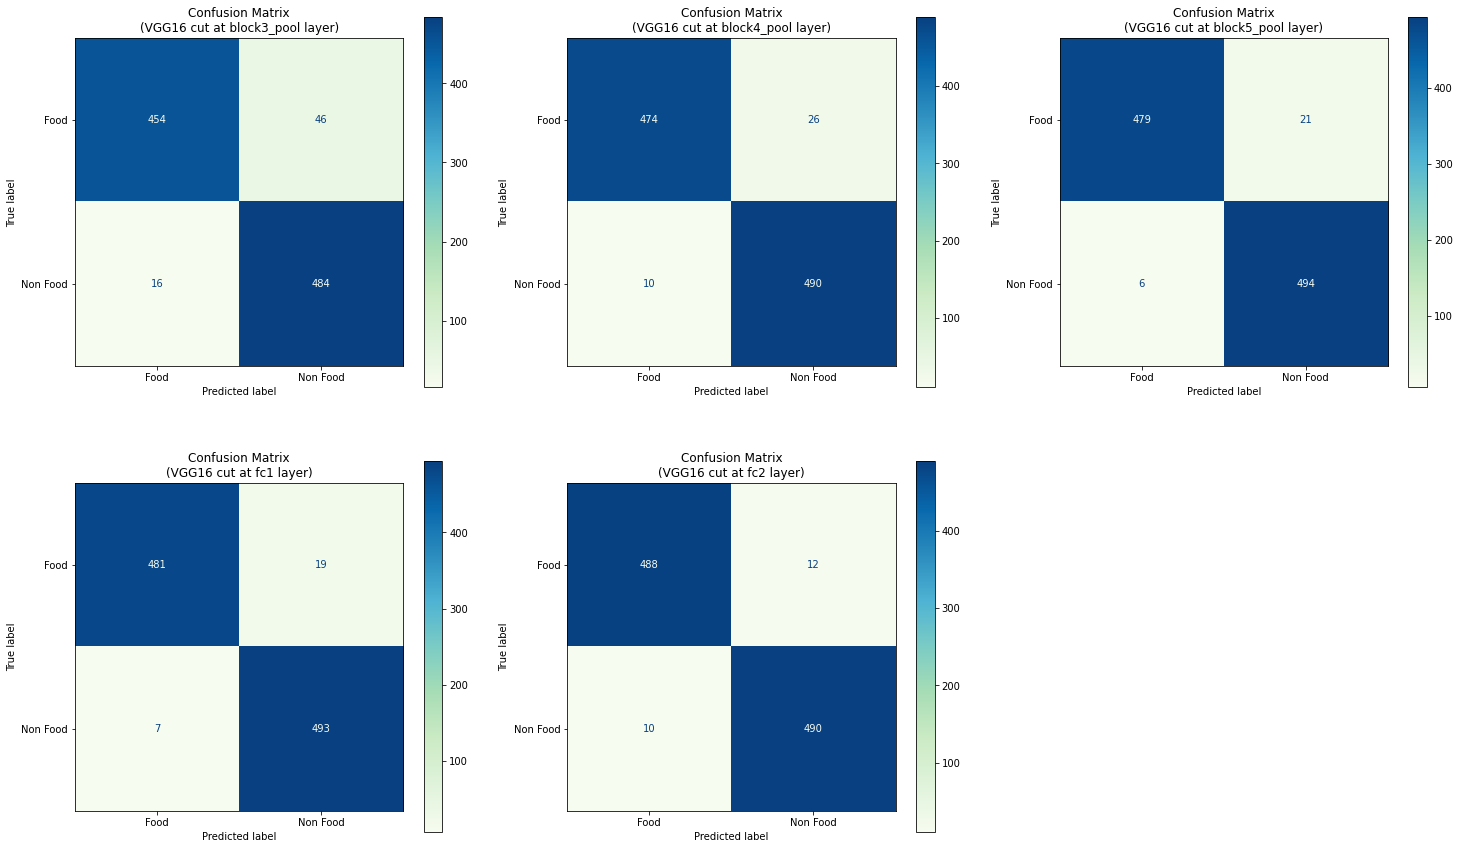

In [16]:
fix, axes = plt.subplots(2, 3, figsize=(25, 15))

for i, (key, (Y_predicted, Y_true)) in enumerate(results.items()):
    axes[i//3][i%3].set_title('Confusion Matrix\n(VGG16 cut at {} layer)'.format(key))
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(Y_true, Y_predicted),
        display_labels=['Food', 'Non Food']
    ).plot(include_values=True, cmap='GnBu', ax=axes[i//3][i%3])

axes[1][2].set_visible(False)
plt.show()

In [38]:
scores = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1': {},
}

for key, (Y_predicted, Y_true) in results.items():
    scores['Accuracy'][key] = accuracy_score(Y_true, Y_predicted)
    scores['Precision'][key] = precision_score(Y_true, Y_predicted, pos_label='food')
    scores['Recall'][key] = recall_score(Y_true, Y_predicted, pos_label='food')
    scores['F1'][key] = f1_score(Y_true, Y_predicted, pos_label='food')


This behaviour can be noticed as well by plotting the values of Accuracy, Precision, Recall and F1-Score metrics.

The most obvious difference is between the VGG16 network cut at Conv5/MaxPooling and the network cut at lower levels (Conv3/MaxPooling and Conv4/MaxPooling). The former achieves a better overall result than the latter.

This happens because at lower levels the network is providing too many features that could pollute the classification step. Reducing the features could provide more significant ones that results in a better abstraction of the image and therefore a better classification.

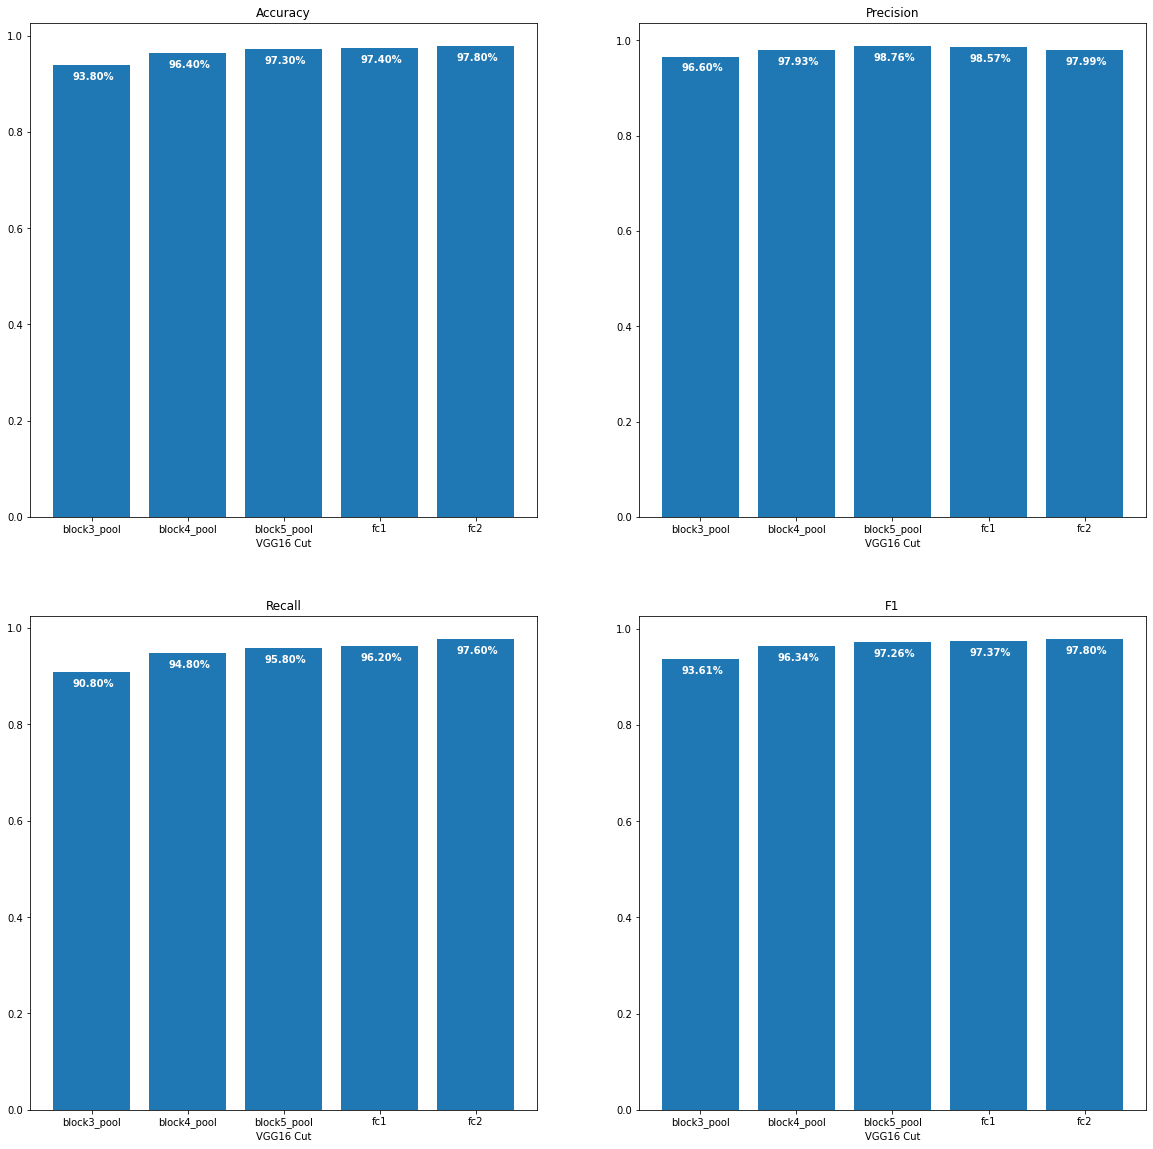

In [40]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, metric in enumerate(metrics):
    ax = axes[i//2][i%2]

    ax.bar(scores[metric].keys(), scores[metric].values())
    ax.set_xlabel('VGG16 Cut')
    ax.set_title(metric)

    for i, value in enumerate(scores[metric].values()):
        ax.text(i - .2, value - 0.03, '{:.2f}%'.format(value*100), color='white', fontweight='bold')

plt.show()